### MMD - Critic on Google Quickdraw Data

Acknowledgement;  This notebook is adjusted from excellent code provided by https://github.com/maxidl/MMD-critic and also the original authors of MMD-critic https://github.com/BeenKim/MMD-critic

In [1]:
import sys
print(sys.executable)

C:\Users\eoind\Anaconda3\envs\mmd-critic\python.exe


In [2]:
import math
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from mmd_critic import Dataset, select_prototypes, select_criticisms
import numpy as np

In [3]:
cwd = Path('.')

In [4]:
from torchvision import transforms
transform_1 = transforms.Compose([transforms.ToTensor()])

### Quickdraw

#### Loading in the google quickdraw data used

In [5]:
x_train_qd = np.load('../Documents/ECML_XKDD_Paper/ICLR_22/interface_prototype-main/ICLR_22/quickdraw_x_train.npy')
y_train_qd = np.load('../Documents/ECML_XKDD_Paper/ICLR_22/interface_prototype-main/ICLR_22/quickdraw_y_train.npy')

In [6]:
xmin, xmax = 0, 1
x_train_qd = ((x_train_qd - x_train_qd.min()) / (x_train_qd.max() - x_train_qd.min())) * (xmax - xmin) + xmin

In [7]:
ds_qd = torch.utils.data.TensorDataset(torch.tensor(x_train_qd), torch.tensor(y_train_qd))

In [8]:
ds_qd_train_data = torch.tensor(x_train_qd)
ds_qd_train_labels = torch.tensor(np.argmax(y_train_qd, axis=1))

In [9]:
xmin, xmax = 0, 1
ds_qd_train_data = ((ds_qd_train_data - ds_qd_train_data.min()) / (ds_qd_train_data.max() - ds_qd_train_data.min())) * (xmax - xmin) + xmin

In [10]:
ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor((ds_qd_train_labels) == 0))[0])

C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2801117212.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor((ds_qd_train_labels) == 0))[0])


In [11]:
samples = [sample[0] for sample in ds_qd]

In [12]:
X = torch.stack(samples).reshape(len(samples), -1)
y = torch.zeros((X.shape[0],), dtype=torch.long)
d = Dataset(X, y)

In [13]:
def prototype_generator_mmd_pixel_qd(class_label):


    cwd = Path('.')
    output_dir = cwd / 'output'
    #imagenet_root = Path('~/ILSVRC2012/')
    #mnist_root = Path('./data/MNIST/')
    #split='train'
    device = torch.device('cpu')
    
    class_label = class_label


    gamma = None

    num_prototypes = 10
    num_criticisms = 10

    kernel_type = 'local'
    #kernel_type = 'global'

    # regularizer = None
    regularizer = 'logdet'
    # regularizer = 'iterative'
    use_image_embeddings = False
    
    make_plots = True
    
    class_name = class_label

    print('==============')
    #print(f'imagenet_root:{imagenet_root.absolute()}')
    print(f'output_dir:{output_dir.absolute()}')
    print(f'target_class:{class_name}')
    print(f'num_prototypes:{num_prototypes}')
    print(f'num_criticisms:{num_criticisms}')
    print(f'gamma:{gamma}')
    print(f'kernel_type:{kernel_type}')
    print(f'regularizer:{regularizer}')
    print(f'make_plots:{make_plots}')
    print('==============\n')

    # torch.set_num_threads(64)

    class_name = class_label
    
    ds_qd = torch.utils.data.TensorDataset(torch.tensor(x_train_qd), torch.tensor(y_train_qd))
    ds_qd_train_data = torch.tensor(x_train_qd)
    ds_qd_train_labels = torch.tensor(np.argmax(y_train_qd, axis=1))
    
    ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])
    samples = [sample[0] for sample in ds_qd]
    
    X = torch.stack(samples).reshape(len(samples), -1)
    y = torch.zeros((X.shape[0],), dtype=torch.long)
    d = Dataset(X, y)
    
    
    if kernel_type == 'global':
        d.compute_rbf_kernel(gamma)
    elif kernel_type == 'local':
        d.compute_local_rbf_kernel(gamma)
    else:
        raise KeyError('kernel_type must be either "global" or "local"')
    print('Done.', flush=True)
    #class_name = class_name.replace(' ', '_')

    # Prototypes
    if num_prototypes > 0:
        print('Computing prototypes...', end='', flush=True)
        prototype_indices = select_prototypes(d.K, num_prototypes)

        prototypes = d.X[prototype_indices]
        prototype_labels = d.y[prototype_indices]

        sorted_by_y_indices = prototype_labels.argsort()
        prototypes_sorted = prototypes[sorted_by_y_indices]
        prototype_labels = prototype_labels[sorted_by_y_indices]
        print('Done.', flush=True)
        print(prototype_indices.sort()[0].tolist())
        
    # Visualize
    if make_plots:
        print('Plotting prototypes...', end='', flush=True)
        num_cols = 8
        num_rows = math.ceil(num_prototypes / num_cols)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
        for i, axis in enumerate(axes.ravel()):
            if i >= num_prototypes:
                axis.axis('off')
                continue
            axis.imshow(prototypes_sorted[i].view(1,28,28).permute(1,2,0).numpy())
            axis.axis('off')
        fig.suptitle(f'{num_prototypes} Prototypes')
        plt.savefig(output_dir / f'{num_prototypes}_prototypes_quickdraw_{class_name}.pdf')
        print('Done.', flush=True)
                
    
    # Criticisms
    if num_criticisms > 0:
        print('Computing criticisms...', end='', flush=True)
        criticism_indices = select_criticisms(d.K, prototype_indices, num_criticisms, regularizer)

        criticisms = d.X[criticism_indices]
        criticism_labels = d.y[criticism_indices]

        sorted_by_y_indices = criticism_labels.argsort()
        criticisms_sorted = criticisms[sorted_by_y_indices]
        criticism_labels = criticism_labels[sorted_by_y_indices]
        print('Done.', flush=True)
        print(criticism_indices.sort()[0].tolist())

    # Visualize
    if make_plots:
        print('Plotting criticisms...', end='', flush=True)
        num_cols = 8
        num_rows = math.ceil(num_criticisms / num_cols)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 0.75))
        for i, axis in enumerate(axes.ravel()):
            if i >= num_criticisms:
                axis.axis('off')
                continue
            axis.imshow(criticisms_sorted[i].view(1,28,28).permute(1,2,0).numpy())
            axis.axis('off')
        fig.suptitle(f'{num_criticisms} Criticisms')
        plt.savefig(output_dir / f'{num_criticisms}_criticisms_imagenet_{class_name}.svg')
        print('Done.', flush=True)

    return prototype_indices.numpy(), criticism_indices.numpy()

output_dir:C:\Users\eoind\MMD-critic\output
target_class:1
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[131, 211, 435, 994, 2732, 2842, 3443, 5967, 6645, 6940]
Plotting prototypes...Done.
Computing criticisms...Done.
[79, 938, 944, 3534, 4415, 4438, 5390, 5760, 5791, 6434]
Plotting criticisms...Done.


(array([5967, 3443,  435, 6645, 2732, 2842,  211,  994, 6940,  131],
       dtype=int64),
 array([4438, 6434, 3534,  938,   79, 4415, 5390, 5791, 5760,  944],
       dtype=int64))

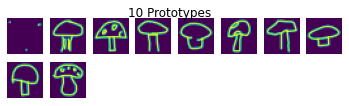

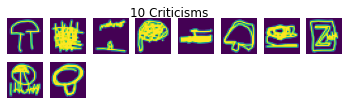

In [38]:
prototype_generator_mmd_pixel_qd(1)

output_dir:C:\Users\eoind\MMD-critic\output
target_class:0
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[1736, 1934, 2149, 2317, 2834, 4751, 5103, 5995, 6069, 6229]
Plotting prototypes...Done.
Computing criticisms...Done.
[302, 700, 2328, 2344, 3988, 5529, 5558, 5579, 5843, 6407]
Plotting criticisms...Done.
output_dir:C:\Users\eoind\MMD-critic\output
target_class:1
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[131, 211, 435, 994, 2732, 2842, 3443, 5967, 6645, 6940]
Plotting prototypes...Done.
Computing criticisms...Done.
[79, 938, 944, 3534, 4415, 4438, 5390, 5760, 5791, 6434]
Plotting criticisms...Done.
output_dir:C:\Users\eoind\MMD-critic\output
target_class:2
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[259, 1246, 1471, 2428, 2538, 2579, 2855, 3139, 3205, 6835]
Plotting prototypes...Done.
Computing criticisms...Done.
[466, 957, 2200, 2231, 2727, 2833, 2851, 3965, 5752, 6806]
Plotting criticisms...Done.
output_dir:C:\Users\eoind\MMD-critic\output
target_class:3
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[461, 530, 624, 1195, 1922, 3340, 3992, 5162, 6315, 6368]
Plotting prototypes...Done.
Computing criticisms...Done.
[1502, 1845, 2741, 3101, 3884, 3913, 4850, 5831, 6045, 6109]
Plotting criticisms...Done.
output_dir:C:\Users\eoind\MMD-critic\output
target_class:4
num_prototypes:10
num_criticisms:10
gamma:None
kernel_type:local
regularizer:logdet
make_plots:True

Setting default gamma=0.0012755102040816326


C:\Users\eoind\AppData\Local\Temp\ipykernel_60664\2078568338.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_qd = torch.utils.data.Subset(ds_qd, torch.where(torch.tensor(ds_qd_train_labels) == class_name)[0])


Done.
Computing prototypes...Done.
[1034, 3154, 3607, 3778, 3875, 4317, 4408, 4646, 5268, 6584]
Plotting prototypes...Done.
Computing criticisms...Done.
[484, 691, 2669, 3161, 3584, 3812, 5139, 5729, 6658, 6764]
Plotting criticisms...Done.


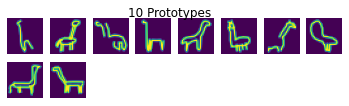

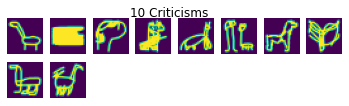

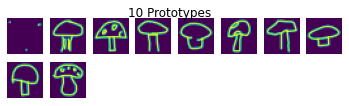

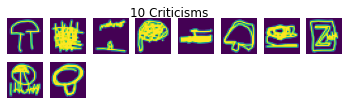

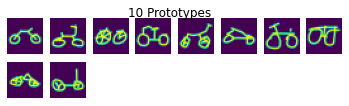

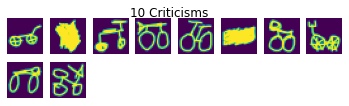

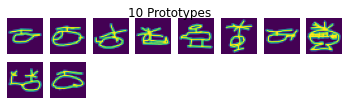

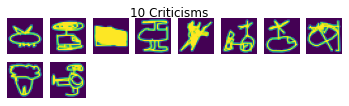

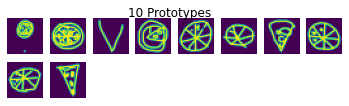

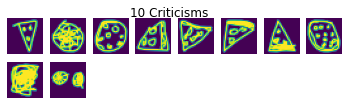

In [15]:
prototype_indices = []
criticism_indices = []

for class_label in [0,1,2,3,4]:
    
    
    p, c = prototype_generator_mmd_pixel_qd(class_label)
    
    prototype_indices.append(p)
    criticism_indices.append(c)

In [16]:
np.save('quickdraw_prototype_indices_mmd_pixel_local.npy', np.array(prototype_indices))
np.save('quickdraw_criticism_indices_mmd_pixel_local.npy', np.array(criticism_indices))

In [41]:
np.where(np.argmax(y_train_qd, axis=1) == 1)[0][435]

2291

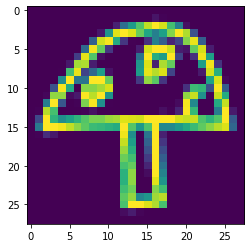

In [42]:
plt.imshow(x_train_qd[2291])